<a href="https://colab.research.google.com/github/EmilyCarroll-del/Michael-J-Fox-Foundation-FOG-in-PD/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!gsutil cp -r gs://fog-data/data/training/tdcsfog .

CommandException: No URLs matched: gs://fog-data/data/training/tdcsfog


In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks/'
%ls

/content/drive/MyDrive/Colab Notebooks
'Random Forest.ipynb'   tlvmc-parkinsons-freezing-gait-prediction/   unlabeled/


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns


In [6]:
extract_dir = '/content/drive/MyDrive/Colab Notebooks/tlvmc-parkinsons-freezing-gait-prediction/'
os.makedirs(extract_dir, exist_ok=True)



In [8]:
fog_path = extract_dir

# List files in the directory
file_names = os.listdir(fog_path)
print(file_names)



['train', 'test']


In [9]:
#create a directory to the training data folder
train_dir = os.path.join(fog_path, 'train')
print(os.listdir(train_dir))

#directory to each folder in train
train_defog_dir = os.path.join(train_dir, 'defog')
train_tdcsfog_dir = os.path.join(train_dir, 'tdcsfog')
train_notype_dir = os.path.join(train_dir, 'notype')

['tdcsfog', 'defog', 'notype']


In [10]:

def process_directory(directory):
    dfs = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)

        # Check if the file is a CSV and process it
        if file_name.endswith('.csv') and os.path.isfile(file_path):
            df = pd.read_csv(file_path) #read csv files
            df['source_directory'] = os.path.basename(directory)  # Add a column to identify the source directory
            df['csv_name'] = os.path.basename(file_name)
            dfs.append(df)

        return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Process each subdirectory
defog = process_directory(train_defog_dir)
tdcsfog = process_directory(train_tdcsfog_dir)
notype = process_directory(train_notype_dir)

#train_df = pd.concat(train_data, ignore_index=True)
print("Data concatenation complete.")

Data concatenation complete.


In [11]:
print(tdcsfog.shape)

tdcsfog['IsFOG'] = tdcsfog[['StartHesitation', 'Walking', 'Turn']].any(axis='columns')
mask = tdcsfog['IsFOG'] != 0
FOG_count = mask.sum()
print(FOG_count)


(4682, 9)
788


In [12]:
'''
print("defog")
display(defog.head())
print("tdcsfog")
display(tdcsfog.head())
print("no type")
display(notype.head())
'''

'\nprint("defog")\ndisplay(defog.head())\nprint("tdcsfog")\ndisplay(tdcsfog.head())\nprint("no type")\ndisplay(notype.head())\n'

Random Forest Model
hyperparameter: number of trees; depth of trees classification problem


In [13]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import scipy.stats as stats


In [14]:
#removing bottom and top 1% outliers

tdcsfog["NewAccV"] = stats.mstats.winsorize(tdcsfog["AccV"], limits=[0.01, 0.01])
tdcsfog["NewAccML"] = stats.mstats.winsorize(tdcsfog["AccML"], limits=[0.01, 0.01])
tdcsfog["NewAccAP"] = stats.mstats.winsorize(tdcsfog["AccAP"], limits=[0.01, 0.01])

In [15]:
#Checking that NewAccV is different from AccV
#(tdcsfog['AccV']-tdcsfog['NewAccV']).unique()
#(tdcsfog['AccML']-tdcsfog['NewAccML']).unique()
#(tdcsfog['AccAP']-tdcsfog['NewAccAP']).unique()

In [16]:
tdcsfog["AccV"] = tdcsfog["NewAccV"]
tdcsfog["AccAP"] = tdcsfog["NewAccAP"]
tdcsfog["AccML"] = tdcsfog["NewAccML"]
tdcsfog = tdcsfog.drop(["NewAccV", "NewAccML", "NewAccAP"], axis = 1)
tdcsfog = tdcsfog.drop(["StartHesitation", "Walking", "Turn"], axis = 1)
#tdcsfog = tdcsfog.drop(["source_directory", "csv_name"], axis = 1)

In [17]:
tdcsfog.head()

,Time,AccV,AccML,AccAP,source_directory,csv_name,IsFOG
0,0,-9.533939,0.566322,-1.413525,tdcsfog,003f117e14.csv,False
1,1,-9.536140,0.564137,-1.440621,tdcsfog,003f117e14.csv,False
2,2,-9.529345,0.561765,-1.429332,tdcsfog,003f117e14.csv,False
3,3,-9.531239,0.564227,-1.415490,tdcsfog,003f117e14.csv,False
4,4,-9.540825,0.561854,-1.429471,tdcsfog,003f117e14.csv,False


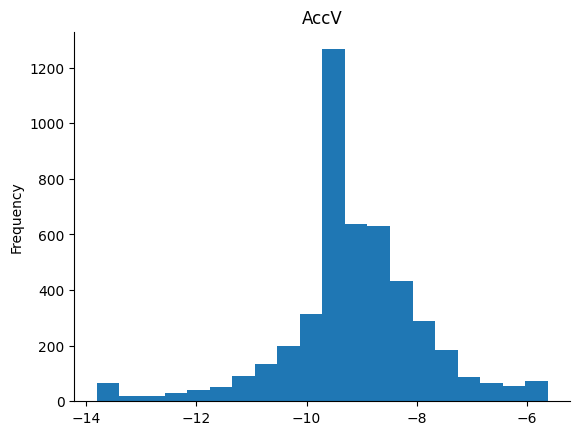

In [ ]:
# @title AccV

from matplotlib import pyplot as plt
tdcsfog['AccV'].plot(kind='hist', bins=20, title='AccV')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [18]:
print(tdcsfog.columns)

Index(['Time', 'AccV', 'AccML', 'AccAP', 'source_directory', 'csv_name',
       'IsFOG'],
      dtype='object')


In [19]:
#AccC, AccML, AccAP data only
X_tdcsfog = tdcsfog[["AccV", "AccML", "AccAP"]].copy()

#FOG event data only
y_tdcsfog = tdcsfog["IsFOG"]

In [20]:
X_train_tdcsfog, X_test_tdcsfog, y_train_tdcsfog, y_test_tdcsfog = train_test_split(X_tdcsfog, y_tdcsfog, test_size=0.33, random_state=123)

In [ ]:
'''
print(X_train_tdcsfog.shape)
print(X_test_tdcsfog.shape)
'''

'\nprint(X_train_tdcsfog.shape)\nprint(X_test_tdcsfog.shape)\n'

In [21]:
model = DecisionTreeClassifier()
List = [20,50,100]
param_grid = dict(key = List)

In [23]:
'''
grid = GridSearchCV(model, param_grid, cv = 5)
grid_search = grid.fit(X_train_tdcsfog, y_train_tdcsfog)
format(grid_search.best_params_)
format(grid_search.best_score_)
'''

ValueError: Invalid parameter 'key' for estimator DecisionTreeClassifier(). Valid parameters are: ['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'].

In [24]:
def train_test_DT(X_train_tdcsfog, X_test_tdcsfog, y_train_tdcsfog, y_test_tdcsfog, depth, leaf=1, crit='entropy'):
  model = DecisionTreeClassifier(criterion = crit, max_depth = depth, min_samples_leaf = leaf)
  model.fit(X_train_tdcsfog, y_train_tdcsfog)
  class_label_predictions = model.predict(X_test_tdcsfog)
  acc_score = accuracy_score(y_test_tdcsfog, class_label_predictions)
  return acc_score

In [30]:
max_depth_range = [2**i for i in range(6)]

acc = []

for md in max_depth_range:
    score = train_test_DT(X_train_tdcsfog, X_test_tdcsfog, y_train_tdcsfog, y_test_tdcsfog, 1, md)
    print('Max Depth=' + str(md) + ', accuracy score: ' + str(score))
    acc.append(float(score))


Max Depth=1, accuracy score: 0.8247089262613195
Max Depth=2, accuracy score: 0.8247089262613195
Max Depth=4, accuracy score: 0.8247089262613195
Max Depth=8, accuracy score: 0.8247089262613195
Max Depth=16, accuracy score: 0.8247089262613195
Max Depth=32, accuracy score: 0.8247089262613195


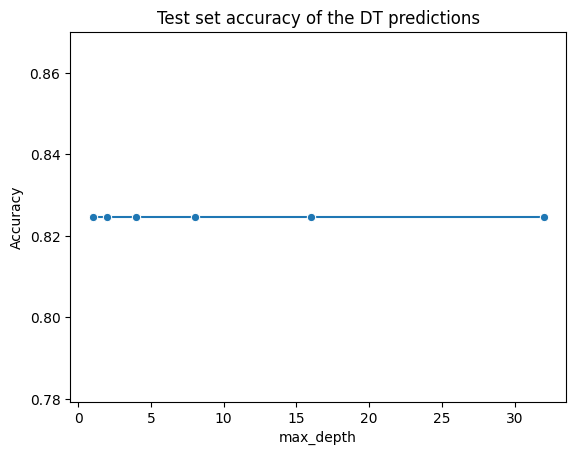

In [35]:
#Graph for comparing accuracy scores
fig = plt.figure()
ax = fig.add_subplot(111)
sns.lineplot(x=max_depth_range, y=acc, marker = 'o')
plt.title('Test set accuracy of the DT predictions')
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
plt.show()

In [ ]:
dt_grid_search = dt_grid.fit(X_train_tdcsfog, y_train_tdcsfog)
print('Done')


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Done


In [ ]:
#Has 20 estimatots/trees
rf_20_model = RandomForestClassifier(criterion='entropy', n_estimators=20)


In [ ]:
rf_20_model.fit(X_train_tdcsfog, y_train_tdcsfog)


RandomForestClassifier(criterion='entropy', n_estimators=20)

In [ ]:
rf_20_preds = rf_20_model.predict_proba(X_test_tdcsfog)
rf_20_predictions = list(rf_20_preds[:, -1])


In [ ]:
#Train 50 estimators/trees
rf_50_model = RandomForestClassifier(criterion='entropy', n_estimators=50)
rf_50_model.fit(X_train_tdcsfog, y_train_tdcsfog)



RandomForestClassifier(criterion='entropy', n_estimators=50)

In [ ]:
rf_50_preds = rf_50_model.predict_proba(X_test_tdcsfog)
rf_50_predictions = list(rf_50_preds[:, -1])

In [ ]:
#Evaluating Performance of the models
#Computing the ROC curves
fpr_20, tpr_20, thresholds_20 = roc_curve(y_test_tdcsfog, rf_20_predictions)
fpr_50, tpr_50, thresholds_100 = roc_curve(y_test_tdcsfog, rf_50_predictions)


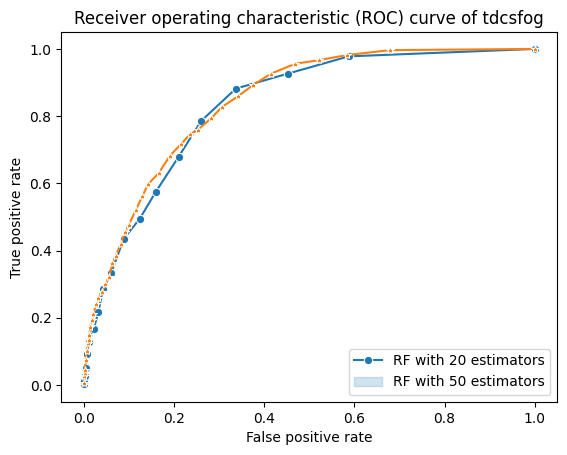

In [ ]:
#Creating comparison of ROC data
fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x=fpr_20, y=tpr_20, marker = 'o')
sns.lineplot(x=fpr_50, y=tpr_50, marker = '*')

plt.title("Receiver operating characteristic (ROC) curve of tdcsfog")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(['RF with 20 estimators', 'RF with 50 estimators'])
plt.show()

In [ ]:
#Area under curve values
auc_20 = auc(fpr_20, tpr_20)
print("AUC of the RF model with 20 estimators is {:.3f}".format(auc_20))

# AUC for rf_100_model
auc_50 = auc(fpr_50, tpr_50)
print("AUC of the RF model with 50 estimators is {:.3f}".format(auc_50))

AUC of the RF model with 20 estimators is 0.832
AUC of the RF model with 50 estimators is 0.843
